## Import Libs

In [51]:
from pathlib import Path
from shutil import get_terminal_size

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.colors import LogNorm

## Define constants, and usefull functions

In [52]:
DATA_DIR: Path = Path("../data/").resolve()

read_csv: pd.DataFrame = lambda fn, dm: pd.read_csv(DATA_DIR / f"{fn}.csv", delimiter=dm)
term_c, term_r = get_terminal_size()
sep: str = "\n" + "+-" * (term_c // 2) + "\n"
print_dfs = lambda dfs: print(*dfs, sep=sep)

## Read csv data we need and merge it into single dataframe (table)

In [53]:
fact_df: pd.DataFrame = read_csv("fact", "\t")
product_df: pd.DataFrame = read_csv("product_dim", "\t")
columns: list[str] = ["Product Name", "Category", "Sub-Category", "Sales", "Quantity", "Discount", "Profit"]
merged_df: pd.DataFrame = pd.merge(left=fact_df, right=product_df, how="left", on="Product ID").loc[:, columns]

## Divide data into 2 groups (Discounted and Undiscounted)

In [54]:
# discounted rows
d_df: pd.DataFrame = merged_df.loc[merged_df["Discount"] > 0].copy()
# undiscounted rows
und_df: pd.DataFrame = merged_df.loc[merged_df["Discount"] == 0].copy()
# print
print_dfs([d_df, und_df])


                                Product Name         Category Sub-Category  \
28103  SAFCO Executive Leather Armchair, Red        Furniture       Chairs   
28104                  Acco Index Tab, Clear  Office Supplies      Binders   
28105  Office Star Rocking Chair, Adjustable        Furniture       Chairs   
28106    Hon Wood Table, with Bottom Storage        Furniture       Tables   
28107    Hon Steel Folding Chair, Set of Two        Furniture       Chairs   
...                                      ...              ...          ...   
49665                BIC Markers, Easy-Erase  Office Supplies          Art   
49666     Dania Corner Shelving, Traditional        Furniture    Bookcases   
49667                Eldon Trays, Wire Frame  Office Supplies      Storage   
49668       Belkin Memory Card, Programmable       Technology  Accessories   
49669          Brother Fax and Copier, Laser       Technology      Copiers   

             Sales  Quantity  Discount      Profit  
28103  344

## Group discounted and undiscounted by products

In [55]:
# groupby func
def groupby(df: pd.DataFrame, by: str | list, agg: str | dict[str, str]) -> pd.DataFrame:
    return df.groupby(by).agg(agg, numeric_only=True).reset_index()

agg: str | dict[str, str] = "sum"

In [56]:
# group by Product Name
d_product_df: pd.DataFrame = groupby(d_df, "Product Name", agg)
und_product_df: pd.DataFrame = groupby(und_df, "Product Name", agg)
d_product_df.index.name = "Product Code"
und_product_df.index.name = "Product Code"
print_dfs([d_product_df, und_product_df])

                                                   Product Name        Sales  \
Product Code                                                                   
0                      #10 Gummed Flap White Envelopes, 100/Box    16.520000   
1                                 #10 Self-Seal White Envelopes     8.872000   
2                    #10 White Business Envelopes,4 1/8 x 9 1/2    50.144002   
3                       #10- 4 1/8" x 9 1/2" Recycled Envelopes   146.832002   
4                  #10- 4 1/8" x 9 1/2" Security-Tint Envelopes    55.008000   
...                                                         ...          ...   
3476          iKross Bluetooth Portable Keyboard + Cell Phon...   100.560001   
3477                                 iOttie HLCRIO102 Car Mount    55.972000   
3478                                        iOttie XL Car Mount   223.887993   
3479          invisibleSHIELD by ZAGG Smudge-Free Screen Pro...   262.653996   
3480                         netTALK DUO

## Do ttest on discounted and undiscounted products to prove there is relation between them and discount affects on other metrics

In [57]:
def ttest_dfs(df_left, df_right, metrics: list[str]) -> pd.DataFrame:
    t_stats, p_values = sp.stats.ttest_ind(df_left.loc[:, metrics], df_right.loc[:, metrics])
    data: dict[str, np.ndarray] = {"Stats": t_stats, "P_value": p_values}
    ttest_df: pd.DataFrame = pd.DataFrame(data, index=metrics)
    ttest_df.index.name = "Metric"
    return ttest_df

In [58]:
ttest_df: pd.DataFrame = ttest_dfs(d_product_df, und_product_df, ["Sales", "Quantity", "Profit"])
print_dfs([ttest_df])

              Stats        P_value
Metric                            
Sales     -5.435963   5.636564e-08
Quantity -10.494108   1.431052e-25
Profit   -29.968519  1.290507e-185


## Visualize discount effects on other metrics sales, quantity, profit

In [59]:
from matplotlib.figure import Figure

def hist2d_dfs(dfs: list[pd.DataFrame], xaxis: str, metrics: list[str], use_x_index: bool = False) -> tuple[Figure, np.ndarray]:
    fig, ax = plt.subplots(nrows=len(metrics), ncols=len(dfs), figsize=(16, 9), tight_layout=True)
    for row in range(len(metrics)):
        for col in range(len(dfs)):
            x: str | np.ndarray = dfs[col][xaxis].values if not use_x_index else dfs[col].index.values
            ax[row][col].hist2d(x, dfs[col][metrics[row]].values, bins=10, norm=LogNorm(), cmap=plt.cm.plasma)
            x_label: str = xaxis if not use_x_index else xaxis + " Count"
            fontsize: int = 16
            fontweight: str = "bold"
            ax[row][col].set_xlabel(x_label, fontsize=fontsize, fontweight=fontweight)
            ax[row][col].set_ylabel(metrics[row], fontsize=fontsize, fontweight=fontweight)
    return fig, ax

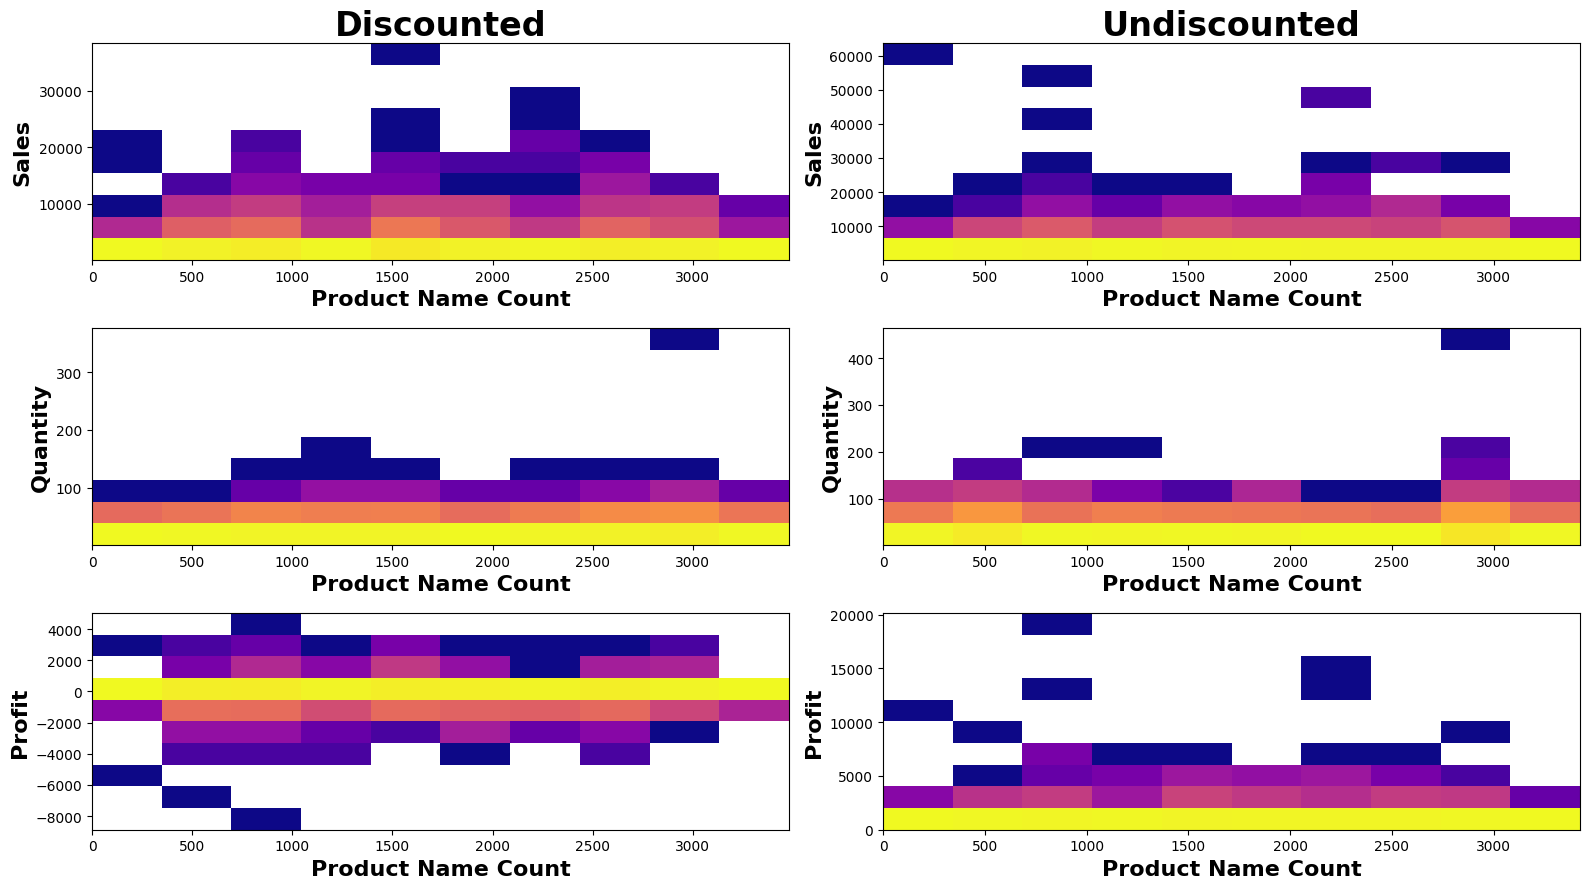

In [60]:
fig, ax = hist2d_dfs(
    [d_product_df, und_product_df],
    "Product Name",
    ["Sales", "Quantity", "Profit"],
    True,
)
ax[0][0].set_title("Discounted", fontsize=24, fontweight="bold")
ax[0][1].set_title("Undiscounted", fontsize=24, fontweight="bold")
plt.show()

## Store results in csv

In [61]:
d_product_df.to_csv(DATA_DIR / "statistics/discounted.csv")
und_product_df.to_csv(DATA_DIR / "statistics/undiscounted.csv")
ttest_df.to_csv(DATA_DIR / "statistics/ttest.csv")